<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/03_MLDeepChem/Predict_Toxicity_of_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__ # 2.6.0.dev

In [ ]:
import deepchem as dc
import numpy as np

## Loading Tox21 toxicity dataset from MoleculeNet



*   **Tasks**: Enzymatic assay which measures whether the molecules in the dataset bind with the biological target in question.
*   **Datasets**: multiple dc.data.Dataset objects, which are training, validation and test sets.
*   **Transformers**: A transformer is an object that modifies a dataset in some way.





In [ ]:
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21()
# _tasks => 12 tasks here corresponds with a particular biological experiment.
print(tox21_tasks)
print(tox21_datasets)

# Separate datasets
train_dataset, valid_dataset, test_dataset = tox21_datasets

['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
(<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>, <DiskDataset X.shape: (783, 1024), y.shape: (783, 12), w.shape: (783, 12), ids: ['N#C[C@@H]1CC(F)(F)CN1C(=O)CNC1CC2CCC(C1)N2c1ncccn1'
 'CN(C)C(=O)NC1(c2ccccc2)CCN(CCC[C@@]2(c3ccc(Cl)c(Cl)c3)CCCN(C(=O)c3ccccc3)C2)CC1'
 'CSc1nnc(C(C)(C)C)c(=O)n1N' ...
 'O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1'
 'C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3C(=C)C[C@@]21CC'
 'NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3c(c2)CCO3)C1'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>, <DiskDataset X.shape: (784, 1024), y.shape: (784, 12), w.shape: (784, 12), ids: ['CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O

#### Exploring the shapes of dataset

In [ ]:
print(train_dataset.X.shape)
print(valid_dataset.X.shape)
print(test_dataset.X.shape)

(6264, 1024)
(783, 1024)
(784, 1024)


In [ ]:
# There are 12 data points, labels, for each sample. These correspond to the 12 tasks.

print(train_dataset.y.shape)
print(valid_dataset.y.shape)
print(test_dataset.y.shape)

(6264, 12)
(783, 12)
(784, 12)


**ISSUE:** The actual experimental dataset for Tox21 did not
test every molecule in every biological experiment. That means that some of these labels are meaningless placeholders. We need to ignore those elements of the arrays when training and testing the model.

If a label has a weight of 0, that label does not affect the loss and is ignored during training.

In [ ]:
# How many labels have actually been measured?

print("Shape: {}, total: {}x{}={}".format(
    train_dataset.w.shape, 
    train_dataset.w.shape[0], 
    train_dataset.w.shape[1],
    train_dataset.w.shape[0] * train_dataset.w.shape[1]
))

print("Measured: {}".format(np.count_nonzero(train_dataset.w)))
print("Missing labels: {}".format(np.count_nonzero(train_dataset.w == 0)))

Shape: (6264, 12), total: 6264x12=75168
Measured: 63647
Missing labels: 11521


### Which transformer are we using?

BalancingTransformer in order to correct for unbalanced data. BalancingTransformer adjusts the weights for individual data points so that the total weight assigned to every class is the same. The loss can be only be decresed by learning to correctly distinguish between classes.

In [ ]:
print(transformers)

## Training an implemented fully connected network (MLP, Multilayer Perceptron).

In [ ]:
# A neural network with a hidden layer and 1000 neurons.
model = dc.models.MultitaskClassifier(n_tasks=12, n_features=1024, layer_sizes=[1000]) 

In [ ]:
model.fit(train_dataset, nb_epoch=10)

0.49523932139078775

## Evaluating the performance

ROC AUC score is a useful metric, given that we have multiples tasks we need to compute the **mean ROC AUC** score across all tasks.

**About ROC AUC**

At this problem we have a trade-off: We want to classify molecules as toxic or nontoxic, but the model outputs continuous numbers, not discrete predictions. We use a threshold value...a low threshold will produce many false positives (predicting a safe molecule is actually toxic). A higher threshold will give fewer false positives but more false negatives (incorrectly predicting that a toxic molecule is safe).

The ROC (Receiver Operating Characteristic) curve is a convenient way to visualize this trade-off.

The ROC AUC is the total area under the ROC curve. AUC provides an indication of the model's ablity to distinguish different classes:
- If there exists any threshold value for which every sample is classified correctly, the ROC AUC score is 1.
- If the model outputs completely random values unrelated to the true classes, the ROC AUC score is 0.5.



In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
# We evaluate the perfomance of the model on a given dataset and using the above metric.
train_scores = model.evaluate(train_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)

print("Train scores: {}".format(train_scores))
print("Test scores: {}".format(test_scores))

Train scores: {'mean-roc_auc_score': 0.9590226869366867}
Test scores: {'mean-roc_auc_score': 0.6851676730697361}


*Note: The model has been overfit.*

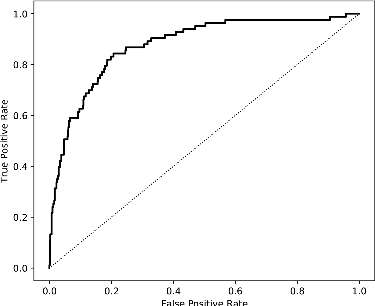

The ROC curve for one of the 12 tasks.